In [1]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
import sklearn
np.random.seed(42)

Changes from previous version: I am shuffling the cAb-Rep before taking the 11867 subset. I also cut out HCDR3 sequences more than 32aa.

In [2]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [3]:
tf.__version__

'2.10.0'

# Preprocessing

In [4]:
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    for i in myfile:
        if i.find("cdr3_aa_seq=") != -1:
            if (len(i.split('cdr3_aa_seq=')[-1].split('size=')[0]) > 32):
                continue
            head.append(i.split('cdr3_aa_seq=')[-1].split('size=')[0])
    np.random.shuffle(head)
    head = head[:11867]
print(head[:5], len(head))
healthy_sequences = head

['CARDPNTAMAFW ', 'CESIHSSSSGYW\n', 'CARRYNWSYKDYFDYW\n', 'VRLKWGRYIPYGLDV ', 'CARAIFGVVIRPRYYYYMDVW\n'] 11867


In [5]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["CDRH3"]]

In [6]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

# print(covid_sequences)

32
32


In [7]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [8]:
covid_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in covid_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((32, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    covid_onehot.append(b)

# print(covid_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((32, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(covid_onehot))

# set infected 1, healthy 0

11867


In [9]:
healthy_lables = [0] * 11867
covid_lables = [1] * 11867

In [10]:
X = np.concatenate((healthy_onehot, covid_onehot))
y = np.concatenate((healthy_lables, covid_lables))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Model

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 20)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-11-24 13:29:25.431507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 13:29:25.431624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=25, validation_data = (X_val, y_val))

Epoch 1/25


2022-11-24 13:29:25.649915: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-24 13:29:25.869201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


601/601 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.7263

2022-11-24 13:29:31.523115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


601/601 [==============================] - 6s 10ms/step - loss: 0.5033 - accuracy: 0.7263 - val_loss: 0.4757 - val_accuracy: 0.7430
Epoch 2/25
601/601 [==============================] - 6s 10ms/step - loss: 0.4421 - accuracy: 0.7570 - val_loss: 0.4605 - val_accuracy: 0.7467
Epoch 3/25
601/601 [==============================] - 6s 10ms/step - loss: 0.3871 - accuracy: 0.7976 - val_loss: 0.4468 - val_accuracy: 0.7523
Epoch 4/25
601/601 [==============================] - 6s 11ms/step - loss: 0.3011 - accuracy: 0.8557 - val_loss: 0.4963 - val_accuracy: 0.7355
Epoch 5/25
601/601 [==============================] - 6s 11ms/step - loss: 0.2089 - accuracy: 0.9089 - val_loss: 0.5890 - val_accuracy: 0.7449
Epoch 6/25
601/601 [==============================] - 7s 11ms/step - loss: 0.1373 - accuracy: 0.9443 - val_loss: 0.7082 - val_accuracy: 0.7533
Epoch 7/25
601/601 [==============================] - 7s 11ms/step - loss: 0.0862 - accuracy: 0.9679 - val_loss: 1.0823 - val_accuracy: 0.7556
Epoch 8/25

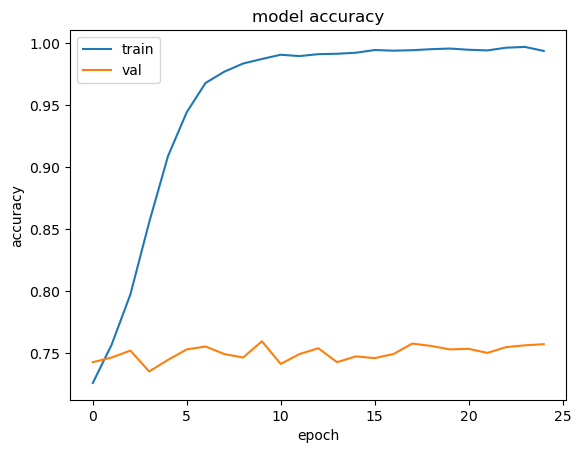

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

In [16]:
model.evaluate(X_test, y_test)

75/75 [==============================] - 1s 7ms/step - loss: 1.8707 - accuracy: 0.7422


[1.8706656694412231, 0.7422072887420654]

In [17]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 13ms/step


2022-11-24 13:32:07.530128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


[array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

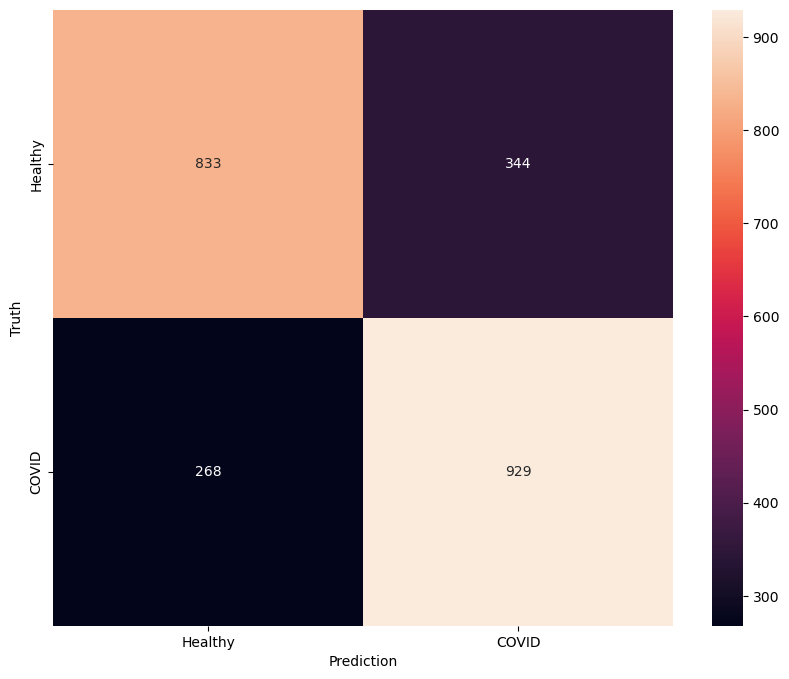

tf.Tensor(
[[833 344]
 [268 929]], shape=(2, 2), dtype=int32)


In [18]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [19]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

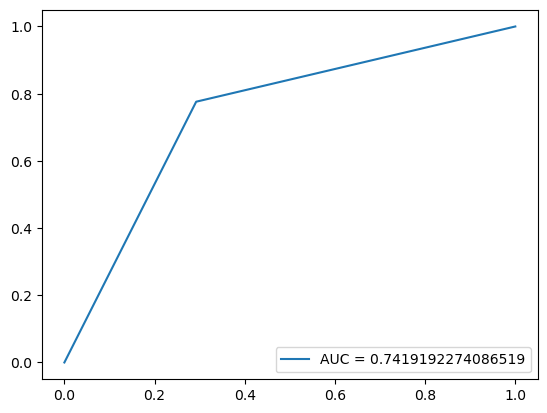

In [20]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()